In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics, svm
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, _tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from logitboost import LogitBoost
# from autogluon.tabular import TabularDataset, TabularPredictor

import imodels
import sys
sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn.graph import barplot
from rulevetting.projects.tbi_pecarn.baseline import Baseline


MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...

# default plotting properties - has to be an easier way then doing this every notebook
TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

C:\Users\hyunsuk\Anaconda3\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [19]:
def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

def predict_stats(y_true, y_pred_prob, verbose = True) :
    '''
    Choose the threshold for probability using Youden's J-statistic (tpr - fpr),
    then prints AUC, accuracy, balanced accuracy, sensitivity, and specificity
    
    input
    ------
    y_true      : true outcome values
    y_pred_prob : predicted probability of being positive (tbi)
    verbose     : Print the statistics or not
    
    output
    ------
    Prints (if verbose = True) and returns the dictionary containing statistics
    (AUC, accuracy, balanced accuracy, sensitivity, specificity)
    '''
    
    from sklearn.metrics import confusion_matrix
    
    fpr, tpr, thresholds = roc_curve(y_tune, y_pred_prob)
    J = tpr - fpr
    thresh = thresholds[np.argmax(J)]  
    y_tune_pred = y_pred_prob > thresh

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_tune_pred, labels=[1, 0])
    
    # Calculating statistics
    n = sum(sum(cm))
    auc = roc_auc_score(y_tune, y_pred_prob)
    acc = (cm[0,0] + cm[1,1]) / n
    sens = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = cm[1,1] / (cm[1,0] + cm[1,1])
    npv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    balacc = (sens + spec) / 2
    
    if verbose :
        print('Confusion Matrix : \n', cm)
        print(f'Prob. threshold : {thresh:.5f}')
        print(f'AUC             : {auc:.3f}')  
        print(f'Accuracy        : {acc:.3f}')
        print(f'Sensitivity     : {sens:.3f}')
        print(f'Specificity     : {spec:.3f}')
        print(f'Balanced Acc.   : {balacc:.3f}')
        print(f'NPV             : {npv:.3f}')

    return {'AUC' : auc, 'Accuracy' : acc, 'Balanced Accuracy' : balacc, 
            "Sensitivity" : sens, "Specificity" : spec, "NPV" : npv}


In [6]:
# Data Generation

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]
/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
##################
# DATA SELECTION #
##################

simple = False    # 43 Columns or 120 Columns
young = True    # Include Age < 2                  (6432 + 2144 + 2145 samples)
old = True       # Include Age > 2                  (19025 + 6342 + 6432 samples)


df_train, df_tune, df_test = Dataset().get_data(simple = simple, young = young, old = old)
outcome_def = 'outcome'
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


In [6]:
X_train.shape

(25458, 119)

# Baseline implementation

In [7]:
def add_binary_variables(data) :
    
    df = data.copy()
    
    df['HemaBinary'] = np.maximum.reduce([df['HemaLoc_Occipital'], df['HemaLoc_Parietal/Temporal']])
    df['LocBinary'] = np.maximum.reduce([df['LocLen_5 sec - 1 min'], df['LocLen_1-5 min'], df['LocLen_>5 min']])
    df['MechBinary'] = df['High_impact_InjSev_High']
    df['HABinary'] = df['HASeverity_Severe']
    df['SeizLen'] = np.maximum.reduce([df['SeizLen_1-5 min'], df['SeizLen_5-15 min'], df['SeizLen_>15 min']])
    df['HemaSizeBinary'] = np.maximum.reduce([df['HemaSize_Large'], df['HemaSize_Medium']])
    df['LocSeparateBinary'] = np.maximum.reduce([df['LOCSeparate_Suspected'], df['LOCSeparate_Yes']])
    df['SFxPalpBinary'] = np.maximum.reduce([df['SFxPalp_Unclear'], df['SFxPalp_Yes']])
    
    return df

def baseline_pred(df) :
    
    young_pred = 100 * df['AgeTwoPlus'] + df.loc[:, ['AMS', 'HemaBinary', 'LocBinary', 'MechBinary', 'SFxPalpBinary']].sum(axis=1) + 1 - df['ActNorm']
    old_pred = 100 * df['AgeTwoPlus'] + df.loc[:, ['AMS', 'LocBinary', 'Vomit', 'MechBinary', 'SFxBas', 'HABinary']].sum(axis=1)
    pred = (young_pred != 100.0) & (old_pred != 200.0)
    
    return pred

In [10]:
df_tune_base = add_binary_variables(df_tune)

y_tune_base_pred = baseline_pred(df_tune_base)
cm = confusion_matrix(y_tune, y_tune_base_pred)
    
# Calculating statistics
n = sum(sum(cm))
acc = (cm[0,0] + cm[1,1]) / n
sens = cm[0,0] / (cm[0,0] + cm[0,1])
spec = cm[1,1] / (cm[1,0] + cm[1,1])
balacc = (sens + spec) / 2

print('Confusion Matrix : \n', cm)
print(f'Accuracy        : {acc:.3f}')
print(f'Sensitivity     : {sens:.3f}')
print(f'Specificity     : {spec:.3f}')
print(f'Balanced Acc.   : {balacc:.3f}')

Confusion Matrix : 
 [[5097 3305]
 [   5   79]]
Accuracy        : 0.610
Sensitivity     : 0.607
Specificity     : 0.940
Balanced Acc.   : 0.774


# Fitting models to simple data - we need a pipeline*

## Logistic regression

100%|██████████████████████████████████████| 3342/3342 [00:03<00:00, 971.34it/s]


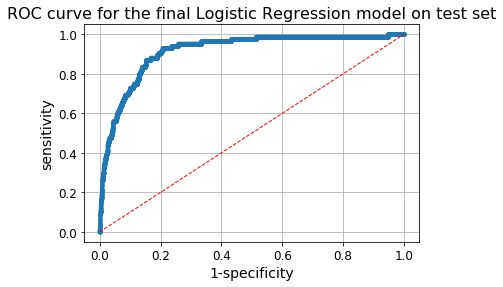

Confusion Matrix : 
 [[  70   14]
 [1708 6694]]
Prob. threshold : 0.00744
AUC             : 0.870
Accuracy        : 0.797
Sensitivity     : 0.833
Specificity     : 0.797
Balanced Acc.   : 0.815
NPV             : 0.998


{'AUC': 0.8697107264710218,
 'Accuracy': 0.7970775394767853,
 'Balanced Accuracy': 0.8150242005871617,
 'Sensitivity': 0.8333333333333334,
 'Specificity': 0.7967150678409902,
 'NPV': 0.9979129397734049}

In [20]:

lamb_vec = [0.001, 0.01, 0.1, 1, 2, 5, 10]

# Now fitting logistic regression
logreg_model = LogisticRegression(solver='liblinear', random_state = 0).fit(X_train, y_train)
roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1])  # Train AUC : 0.9513

# Tuning logistic regression
roc_tune = []
acc_tune = []

for lamb in lamb_vec :
    logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = lamb).fit(X_train, y_train)
    roc_tune.append(roc_auc_score(y_tune, logreg_model.predict_proba(X_tune)[:, 1]))
    acc_tune.append(logreg_model.score(X_tune, y_tune))
    
np.around(roc_tune, 5) # [0.90894, 0.91271, 0.91609, 0.91635, 0.91627, 0.91622, 0.91627]
np.around(acc_tune, 5) # [0.98376, 0.98629, 0.9871 , 0.98687, 0.98687, 0.98687, 0.98687]

best_lamb = lamb_vec[np.argmax(np.array(roc_tune))]

'''
# Using 1 as final regularization
logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = lamb).fit(pd.concat([X_train, X_tune], axis = 0), 
                                                                                      np.hstack((y_train, y_tune)))
print(roc_auc_score(y_simp_test, logreg_model.predict_proba(X_simp_test)[:, 1]))  # 0.94451
print(logreg_model.score(X_simp_test, y_simp_test))  # 0.98583
'''

# Plot for the best result of tuning
logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = best_lamb).fit(X_train, y_train)
validation.all_stats_curve(y_tune, logreg_model.predict_proba(X_tune)[:, 1], plot = True)
plt.title('ROC curve for the final Logistic Regression model on test set')
plt.show()

#print(roc_auc_score(y_tune, logreg_model.predict_proba(X_tune)[:, 1]))  # 0.86971
#print(logreg_model.score(X_tune, y_tune))   # 0.98998
#print(classification_report(y_tune, logreg_model.predict(X_tune)))  
predict_stats(y_tune, logreg_model.predict_proba(X_tune)[:, 1])

In [21]:
best_lamb

0.1

## Boosted (LogitBoost & AdaBoost)

Confusion Matrix : 
 [[  41   43]
 [1011 7391]]
Prob. threshold : 0.00000
AUC             : 0.701
Accuracy        : 0.876
Sensitivity     : 0.488
Specificity     : 0.880
Balanced Acc.   : 0.684
NPV             : 0.994


/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Confusion Matrix : 
 [[  69   15]
 [1638 6764]]
Prob. threshold : 0.48733
AUC             : 0.865
Accuracy        : 0.805
Sensitivity     : 0.821
Specificity     : 0.805
Balanced Acc.   : 0.813
NPV             : 0.998


/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


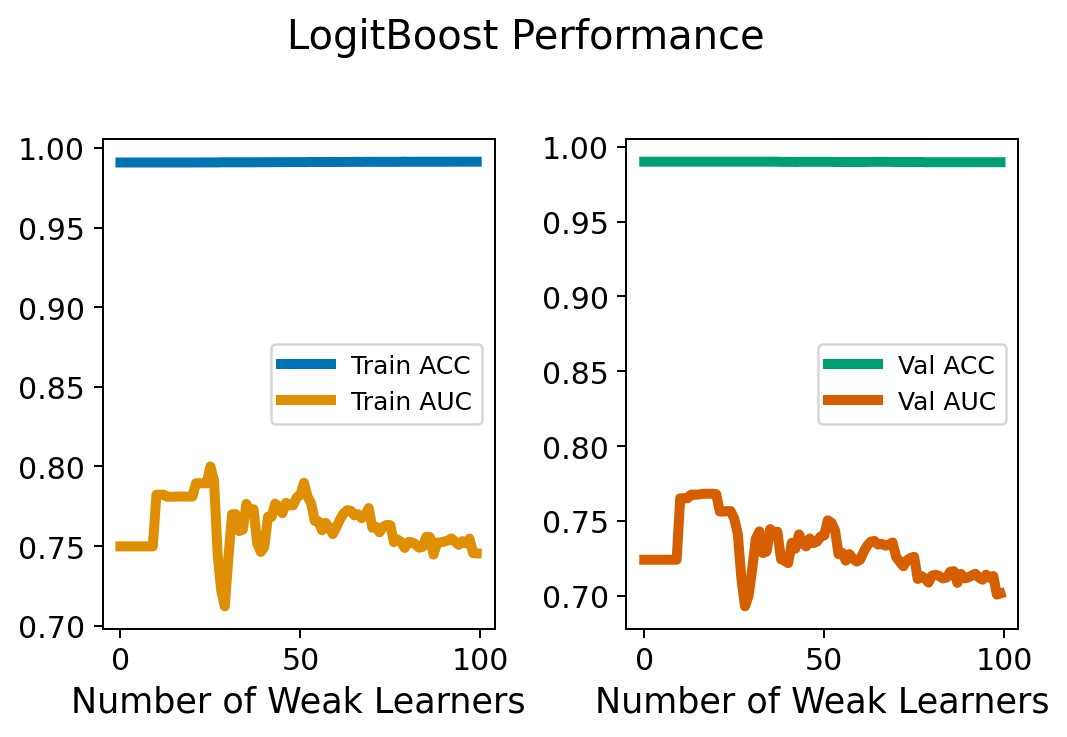

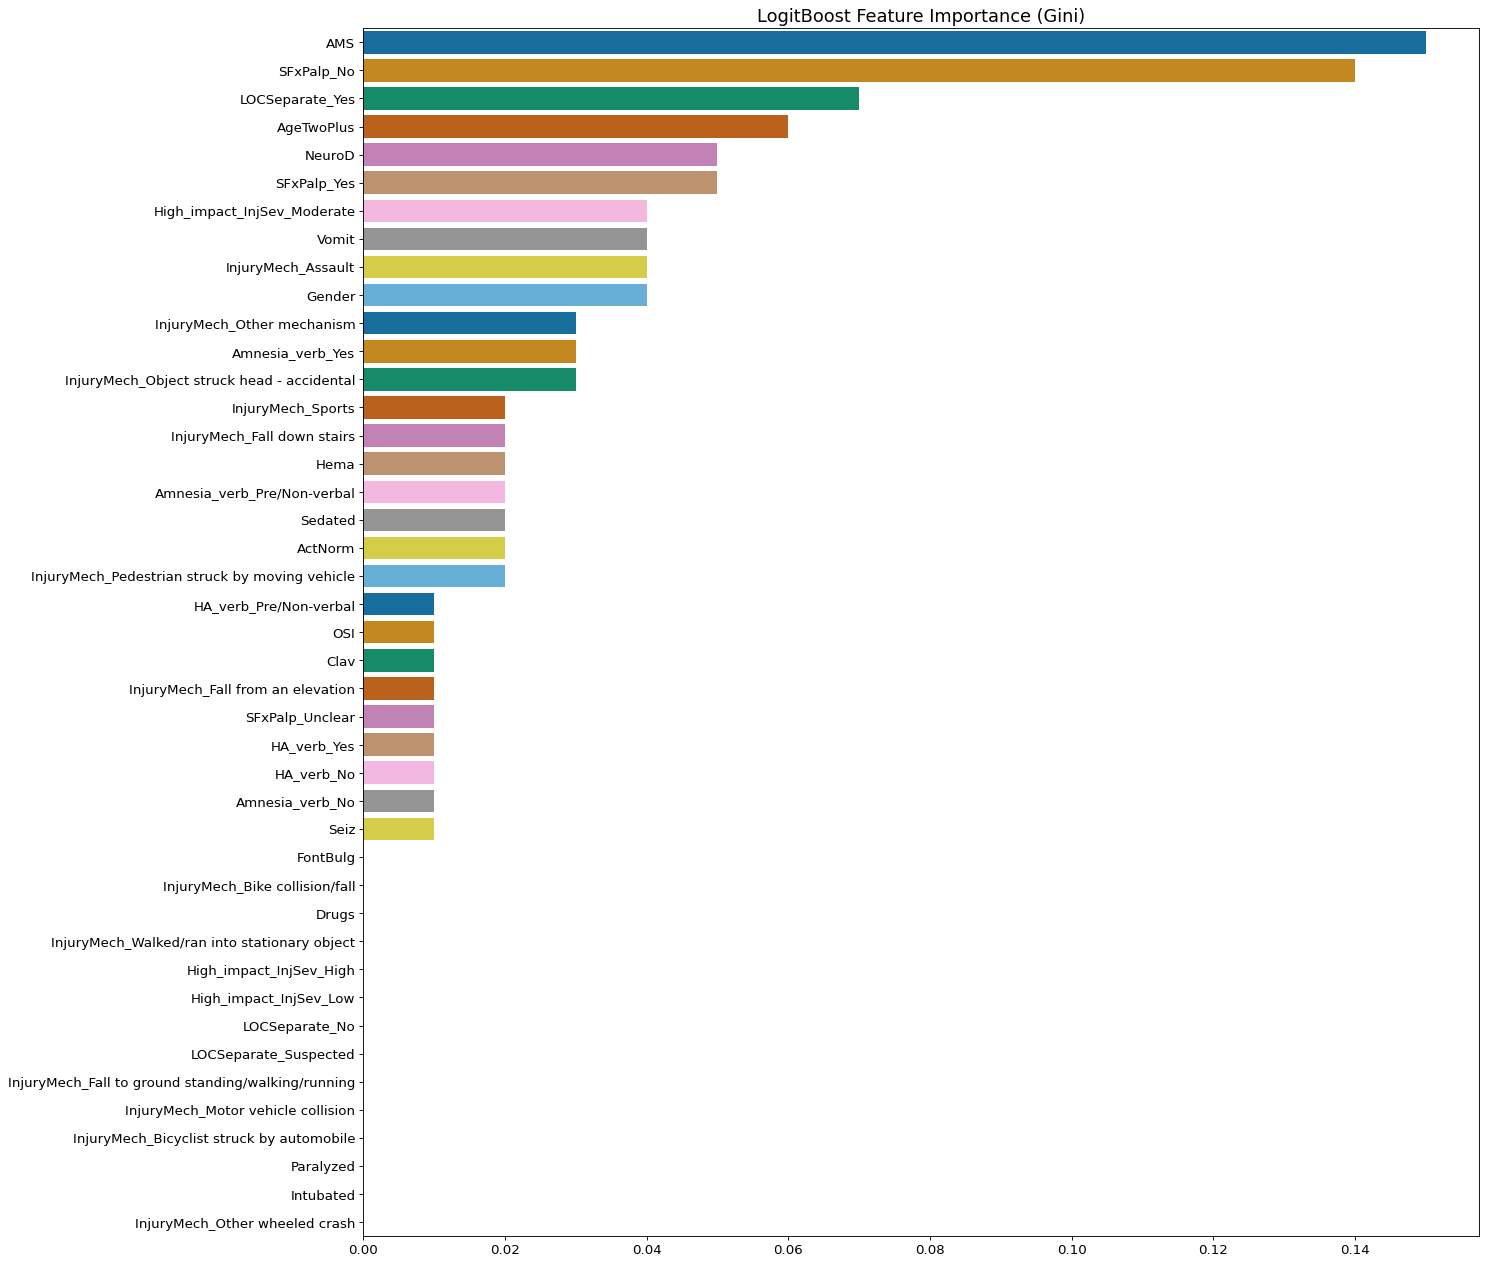

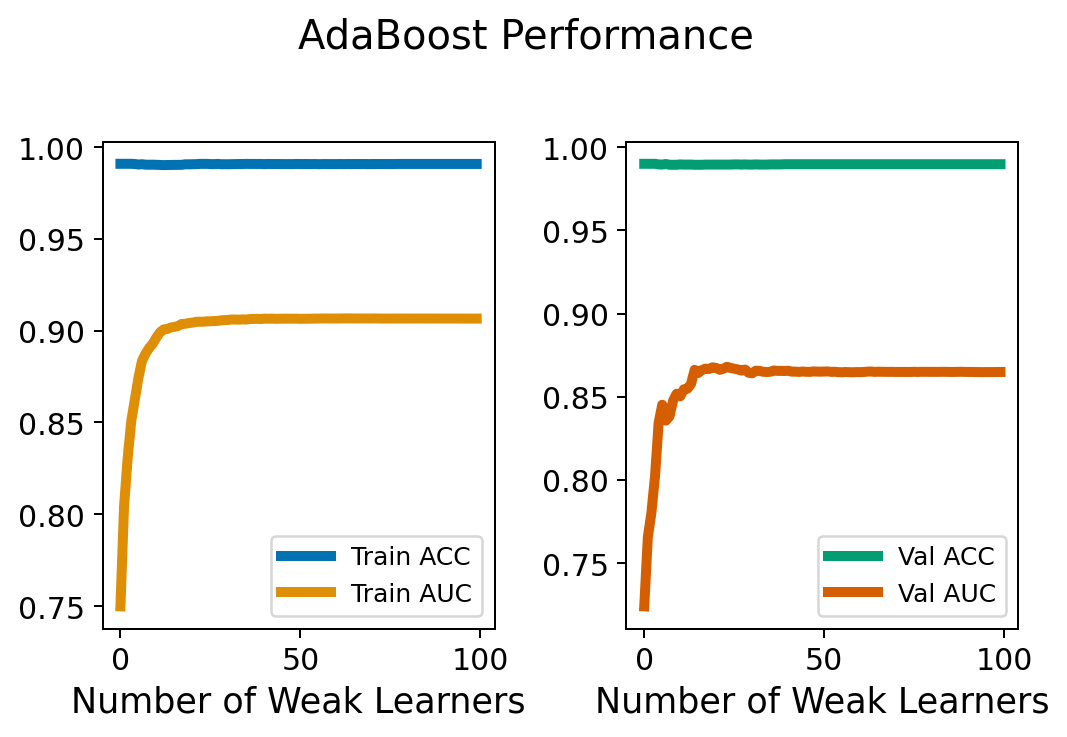

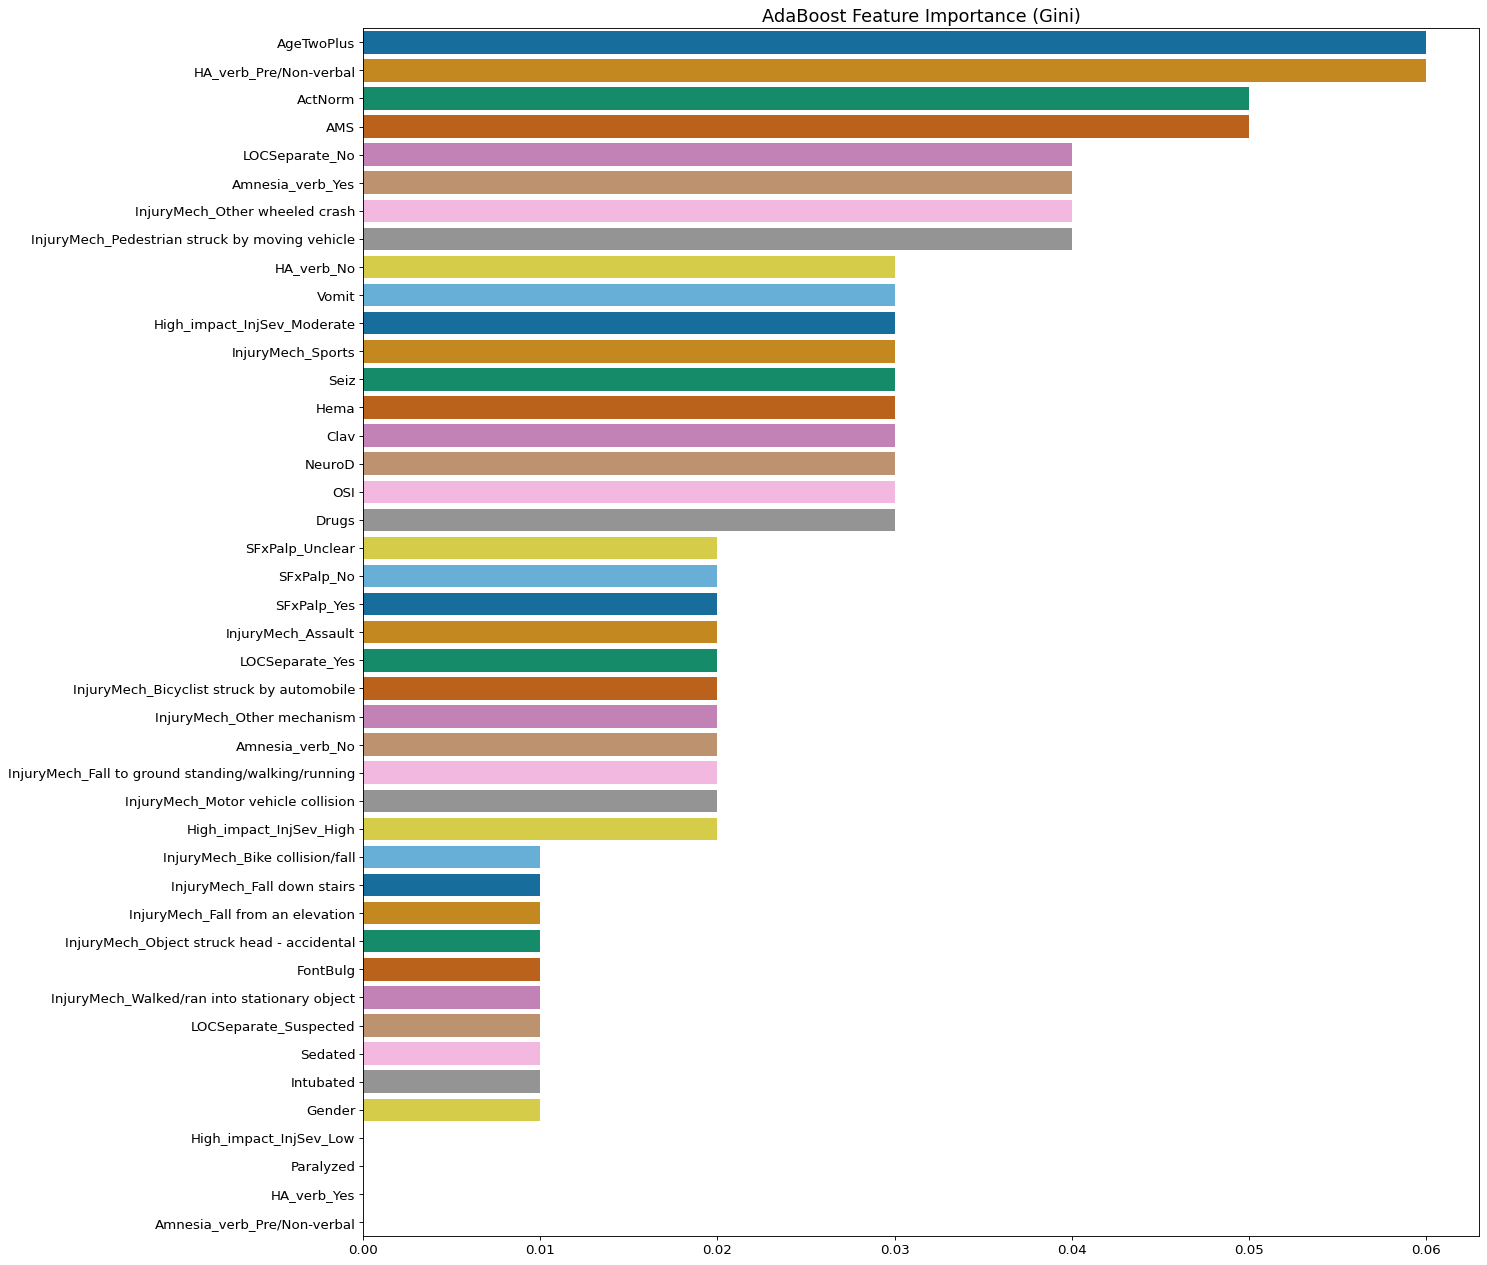

In [24]:
import warnings

def fit_eval_boosted(model, X_train, y_train, X_val, y_val, title_str):
    # Fit model
    model.fit(X_train, y_train)
    
    # Find accuracies on train/val sets
    # This takes ~2 minutes to run
    auc_train = []
    acc_train = []
    auc_val = []
    acc_val = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_pred = list(model.staged_predict_proba(X_train))
        val_pred = list(model.staged_predict_proba(X_val))
        for tp in train_pred:
            auc_train.append(roc_auc_score(y_train, tp[:, 1]))
            acc_train.append((y_train == tp.argmax(axis=1)).mean())
            
        for vp in val_pred:
            auc_val.append(roc_auc_score(y_val, vp[:, 1]))
            acc_val.append((y_val == vp.argmax(axis=1)).mean())

    # Print out the stats
    predict_stats(y_val, vp[:, 1], verbose = True)
            
    # Plot ACC/AUC as function of number of weak learners
    plt.figure()
    plt.suptitle(title_str + " Performance", y=1.02)

    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label="Train ACC", color=color_list[0])
    plt.plot(auc_train, label="Train AUC", color=color_list[1])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_val, label="Val ACC", color=color_list[2])
    plt.plot(auc_val, label="Val AUC", color=color_list[3])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.tight_layout()
    
    # Plot Feature Importances
    barplot(pd.Series(dict(zip(X_train.columns, 
                           model.feature_importances_))).sort_values(ascending=False),
        False, title_str + " Feature Importance (Gini)"
       )
    
    return (model, {"acc_train" : acc_train, "auc_train" : auc_train, "acc_val" : acc_val, "auc_val" : auc_val})

# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)
lboost = LogitBoost(n_estimators=100, random_state=0)
lboost, lboost_perf = fit_eval_boosted(lboost, X_train, y_train, X_tune, y_tune, "LogitBoost")

# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)
aboost = AdaBoostClassifier(n_estimators=100, random_state=0)
aboost, aboost_perf = fit_eval_boosted(aboost, X_train, y_train, X_tune, y_tune, "AdaBoost")

## Decision Tree

In [23]:
# decision tree traversing func
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED 
                    else "Undefined!" for i in tree_.feature]
    paths = []
    path = []
    
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)    
    samples_count = [p[-1][1] for p in paths]
    sorted_samples = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(sorted_samples)]
    rules = []
    for path in paths:
        rule = "if "
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
            rule += '\n'
            
        rule += " then\n"
        if class_names is None:
            rule += "response: " + str(np.round(path[-1][0][0][0], 3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"\t class: {class_names[l]} (prob: {np.round(100 * classes[l] / np.sum(classes), 2)}%)"
        rule += f" | {path[-1][1]:,} samples\n\n"
        rules += [rule]
        
    return rules

# Tuning the depth of the tree
roc_tune = []
acc_tune = []
for depth in range(2, 8):
    
    dt = DecisionTreeClassifier(max_depth=depth, class_weight={0: 1, 1:100})
    dt.fit(X_train, y_train)
    roc_tune.append(roc_auc_score(y_tune, dt.predict_proba(X_tune)[:, 1]))
    acc_tune.append(dt.score(X_tune, y_tune))
    # Print out the stats
    predict_stats(y_tune, dt.predict_proba(X_tune)[:, 1], verbose = True)

print(f'ROC Scores: {np.around(roc_tune, 2)}\n')
print(f'ACC Scores: {np.around(acc_tune, 2)}\n')


# NOT USING TEST SET FOR THE MOMENT
'''
# use the depth 5
depth = 5
dt = DecisionTreeClassifier(max_depth=depth, class_weight={0: 1, 1:100})
dt.fit(X_train, y_train)
print(f'ROC of depth {depth}: {roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])}')
print(f'ACC of depth {depth}: {dt.score(X_test, y_test)}')
validation.all_stats_curve(y_test, dt.predict_proba(X_test)[:, 1], plot=True)
plt.title('ROC Curve of final Decision Tree on Test Set')
plt.show()
'''

# important features
print('Feature Importances:\n')
for col, val in sorted(zip(X_train.columns, dt.feature_importances_), key=lambda x: x[1], reverse=True)[:10]:
    print(f'{col:10}{val:10.3f}')

# plotting decision tree
fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names = X_train.columns, class_names = ['No ciTBI', 'ciTBI'], filled=True)

# plotting probabilities for the different possibilities
print('\n')
rules = get_rules(dt, X_train.columns, ['No ciTBI', 'ciTBI'])
for rule in rules:
    print(rule)

Confusion Matrix : 
 [[   0   84]
 [   0 8402]]
Prob. threshold : 0.82097
AUC             : 0.724
Accuracy        : 0.990
Sensitivity     : 0.000
Specificity     : 1.000
Balanced Acc.   : 0.500
NPV             : 0.990
Confusion Matrix : 
 [[  48   36]
 [1038 7364]]
Prob. threshold : 0.54117
AUC             : 0.771
Accuracy        : 0.873
Sensitivity     : 0.571
Specificity     : 0.876
Balanced Acc.   : 0.724
NPV             : 0.995
Confusion Matrix : 
 [[  58   26]
 [2100 6302]]
Prob. threshold : 0.40816
AUC             : 0.773
Accuracy        : 0.749
Sensitivity     : 0.690
Specificity     : 0.750
Balanced Acc.   : 0.720
NPV             : 0.996
Confusion Matrix : 
 [[  52   32]
 [1389 7013]]
Prob. threshold : 0.56457
AUC             : 0.771
Accuracy        : 0.833
Sensitivity     : 0.619
Specificity     : 0.835
Balanced Acc.   : 0.727
NPV             : 0.995
Confusion Matrix : 
 [[  61   23]
 [1787 6615]]
Prob. threshold : 0.39705
AUC             : 0.783
Accuracy        : 0.787
Sensit

## SVM

In [16]:
roc_tune = []
acc_tune = []
for c in [2**(-3), 2**(-2), 2**(-1), 1, 2**(1), 2**(2), 2**(3), 2**(-1.75), 2**(-1.5), 2**(-1.25), 2**(-0.75), 2**(-0.5)]:
    svm_v = svm.SVC(C=c, probability=True).fit(X_train, y_train)
    roc_tune.append(roc_auc_score(y_tune, svm_v.predict_proba(X_tune)[:, 1]))
    acc_tune.append(svm_v.score(X_tune, y_tune))

print("Validation AUC:", np.around(roc_tune, 5))
print("Validation ACC:", np.around(acc_tune, 5))

# choosing c=1
svm_final = svm.SVC(C=1, probability=True).fit(pd.concat([X_train], axis=0), np.hstack((y_train)))

# Print out the stats
predict_stats(y_tune, svm_final.predict_proba(X_tune)[:, 1], verbose = True)
#print("Test AUC:", roc_auc_score(y_test, svm_final.predict_proba(X_test)[:, 1])) 
#print("Test ACC:", svm_final.score(X_test, y_test))

# NOT USING TEST SET FOR THE MOMENT
'''
# Plot the result for the test set
validation.all_stats_curve(y_test, svm_final.predict_proba(X_test)[:, 1], plot = True)
plt.title('ROC curve for the final SVM model on test set')
plt.show()
'''

KeyboardInterrupt: 

In [25]:
svm_final = svm.SVC(C=1, probability=True).fit(pd.concat([X_train], axis=0), np.hstack((y_train)))

# Print out the stats
predict_stats(y_tune, svm_final.predict_proba(X_tune)[:, 1], verbose = True)

Confusion Matrix : 
 [[  34   50]
 [1203 7199]]
Prob. threshold : 0.01442
AUC             : 0.644
Accuracy        : 0.852
Sensitivity     : 0.405
Specificity     : 0.857
Balanced Acc.   : 0.631
NPV             : 0.993


{'AUC': 0.6440742566962514,
 'Accuracy': 0.8523450388875795,
 'Balanced Accuracy': 0.6307908547851419,
 'Sensitivity': 0.40476190476190477,
 'Specificity': 0.8568198048083789,
 'NPV': 0.9931024968961236}

## Bayesian Rule List   - I just let simp_ exist

In [26]:
def simp_predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_simp_train, X_simp_tune],
                            [y_simp_train, y_simp_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BigDataRuleListClassifier(listlengthprior=2, max_iter=10000, class1label=1, verbose=False)
brl.fit(X_simp_train, y_simp_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

training bayesian_rule_list...


AttributeError: module 'imodels' has no attribute 'BigDataRuleListClassifier'

In [47]:
print(brl)

(Untrained RuleListClassifier)


## Rulefit

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 505.36it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

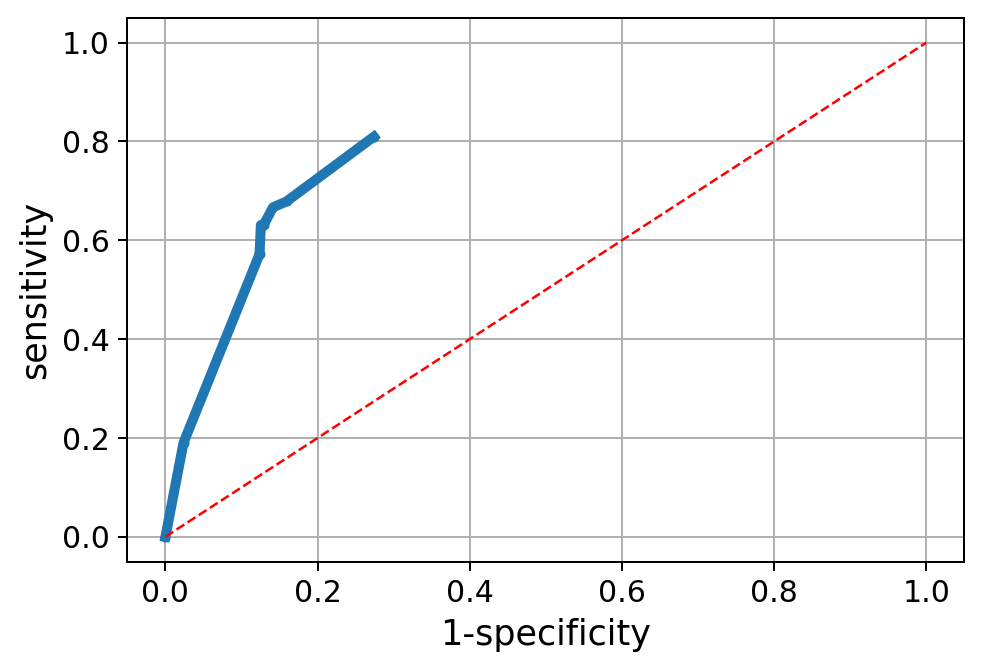

In [28]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)

feature_names = X_train.columns

rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [29]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
43,AMS <= 0.5 and SFxPalp_Yes <= 0.5,-0.00
46,AMS <= 0.5 and InjuryMech_Other wheeled crash <= 0.5,-0.00
44,AMS <= 0.5 and SFxPalp_No > 0.5,-0.02
45,High_impact_InjSev_High <= 0.5 and SFxPalp_Yes <= 0.5,-0.00


## Greedy (CART) Rule List

/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 710.68it/s]


mean 0.009 (25458 pts)
if AMS >= 1 then 0.044 (3307 pts)
mean 0.004 (22151 pts)
if feat 34 >= 1 then 0.075 (80 pts)
mean 0.004 (22071 pts)
if feat 13 >= 1 then 0.011 (3151 pts)
mean 0.002 (18920 pts)
if feat 40 >= 1 then 0.039 (103 pts)
mean 0.002 (18817 pts)
if feat 9 >= 1 then 0.016 (386 pts)
mean 0.002 (18431 pts)
if feat 22 >= 1 then 0.016 (182 pts)
mean 0.002 (18249 pts)
if feat 18 >= 1 then 0.006 (1256 pts)
mean 0.001 (16993 pts)
if feat 36 >= 1 then 0.003 (6788 pts)
mean 0.0 (10205 pts)
if feat 6 >= 1 then 0.002 (1133 pts)



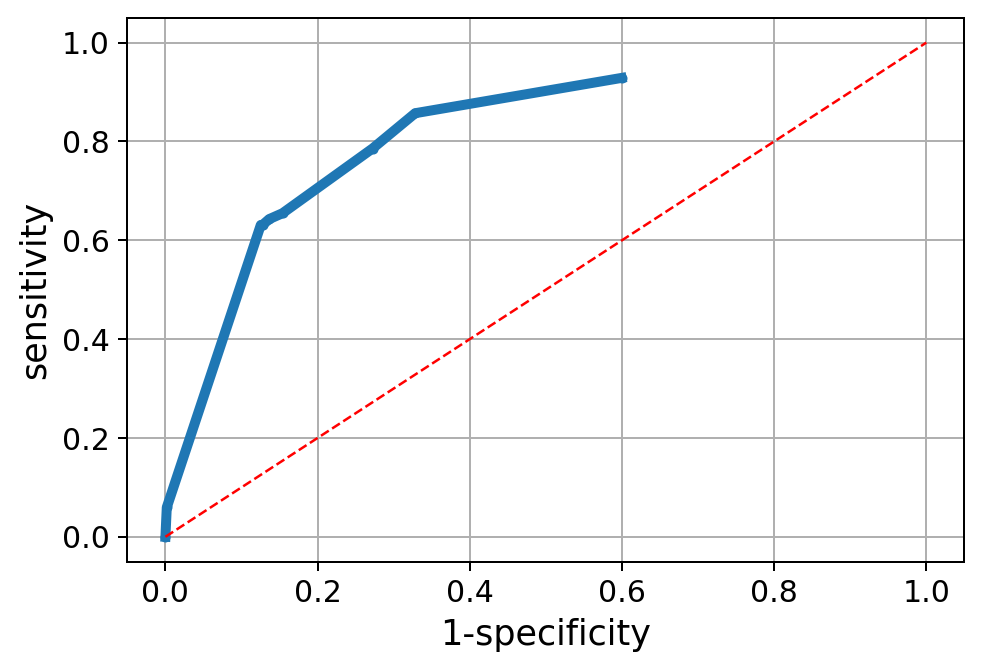

In [30]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

## Random Forest

In [35]:
# # specify a decision tree with a maximum depth
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Print out the stats
predict_stats(y_tune, rf.predict_proba(X_tune)[:, 1], verbose = True)

imps = rf.feature_importances_.round(3)
args = np.argsort(imps)
imps = imps[args]
feats = np.array(feature_names)[args]
for imp, feat in zip(imps, feats):
     print(feat, imp)

Confusion Matrix : 
 [[  51   33]
 [1030 7372]]
Prob. threshold : 0.00860
AUC             : 0.759
Accuracy        : 0.875
Sensitivity     : 0.607
Specificity     : 0.877
Balanced Acc.   : 0.742
NPV             : 0.996
Intubated 0.0
Paralyzed 0.0
FontBulg 0.002
InjuryMech_Walked/ran into stationary object 0.003
Sedated 0.004
InjuryMech_Fall to ground standing/walking/running 0.006
High_impact_InjSev_Low 0.007
InjuryMech_Fall down stairs 0.008
InjuryMech_Assault 0.009
InjuryMech_Bicyclist struck by automobile 0.009
InjuryMech_Bike collision/fall 0.01
InjuryMech_Sports 0.012
InjuryMech_Other wheeled crash 0.013
SFxPalp_Unclear 0.013
Drugs 0.016
SFxPalp_Yes 0.016
LOCSeparate_Suspected 0.017
InjuryMech_Object struck head - accidental 0.017
High_impact_InjSev_Moderate 0.018
InjuryMech_Pedestrian struck by moving vehicle 0.018
Seiz 0.02
SFxPalp_No 0.02
Amnesia_verb_Pre/Non-verbal 0.02
High_impact_InjSev_High 0.021
HA_verb_Pre/Non-verbal 0.021
InjuryMech_Other mechanism 0.021
NeuroD 0.022
Amne

## Autogluon - autoML stuff, can't download it for some reason...

In [36]:
train_data = X_train
train_data['outcome'] = y_train
predictor = TabularPredictor(label='outcome').fit(train_data, presets='interpretable', time_limit=8, verbosity=2)

NameError: name 'TabularPredictor' is not defined

In [ ]:
predictor.leaderboard(silent=True)

In [ ]:
predictor.interpretable_models_summary()

In [ ]:
predictor.print_interpretable_rules()

# Analyze Results

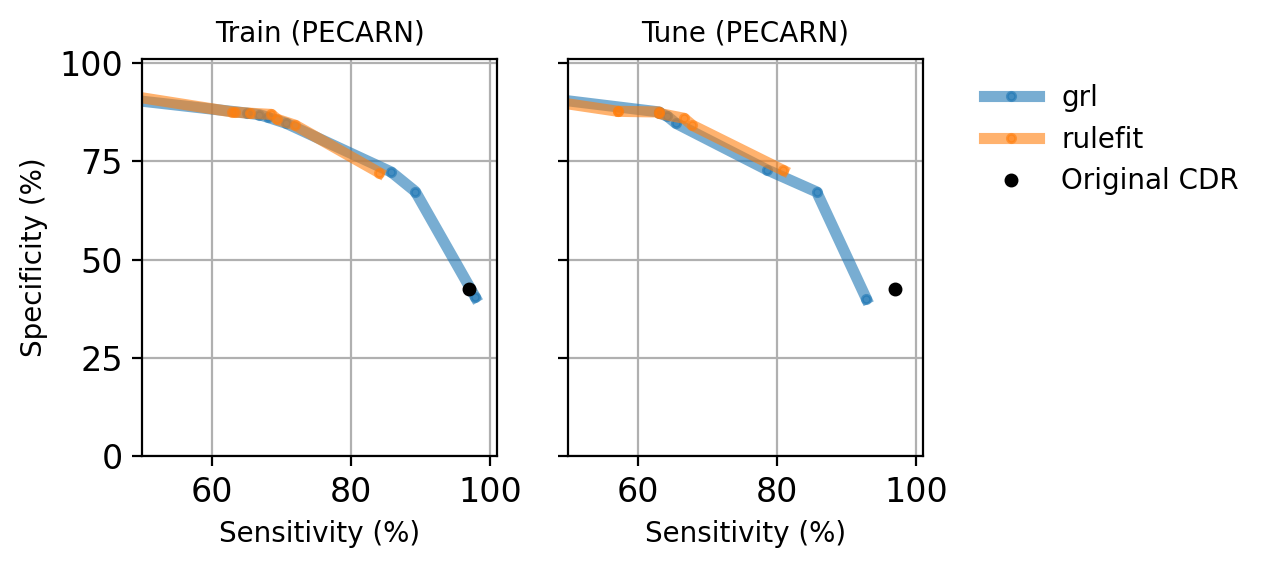

In [37]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (PECARN)', 'Tune (PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
plt.savefig('figs/metrics_3_splits')
plt.show()

In [38]:
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'brier_score', 'f1']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                m = r['model']

                # add more stats
                for x, y, suff in zip([X_train, X_tune],
                                      [y_train, y_tune],
                                      ['_train', '_tune']):
                    if suff == suffix:
                        stats, threshes = validation.all_stats_curve(y, m.predict_proba(x)[:, 1],
                                                                     plot=suffix == '_tune')
                        preds_proba = m.predict_proba(x)[:, 1]
                        brier_score = metrics.brier_score_loss(y, preds_proba)

                # pick best vals
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    if not k == 'brier_score':
                        #                         print('k', k)
                        vals[k].append(stats[k][best_idx])
                vals['brier_score'].append(brier_score)
                fnames.append(fname[:-4])
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()


suffixes = ['_train', '_tune']  # _train, _test1, _test2
stats_list = {}
for i, suffix in enumerate(suffixes):
    stats_list[suffix] = print_metrics(suffix)

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 378.43it/s]


ValueError: X.shape[1] = 44 should be equal to 43, the number of features at training time. Please reshape your data.

In [38]:
stats_list['_train']

,decision_tree,grl,rulefit
sens,1.00,0.95,0.90
spec,0.20,0.63,0.63
ppv,0.02,0.04,0.04
npv,1.00,1.00,1.00
lr+,1.26,2.58,2.47
lr-,0.00,0.08,0.15
brier_score,0.61,0.01,0.08
f1,0.04,0.08,0.07


In [39]:
stats_list['_tune']

,decision_tree,grl,rulefit
sens,0.98,0.93,0.95
spec,0.19,0.68,0.62
ppv,0.02,0.05,0.04
npv,1.00,1.00,1.00
lr+,1.20,2.90,2.52
lr-,0.13,0.11,0.08
brier_score,0.62,0.02,0.08
f1,0.04,0.09,0.08
